# Determination of the camera bias setting

The bias of dedicated astronomical cameras is adjustable. It must be set not too low so that data values are not clipped, but not too high so that the dynamic range is reduced.

(1, 3000000.0)

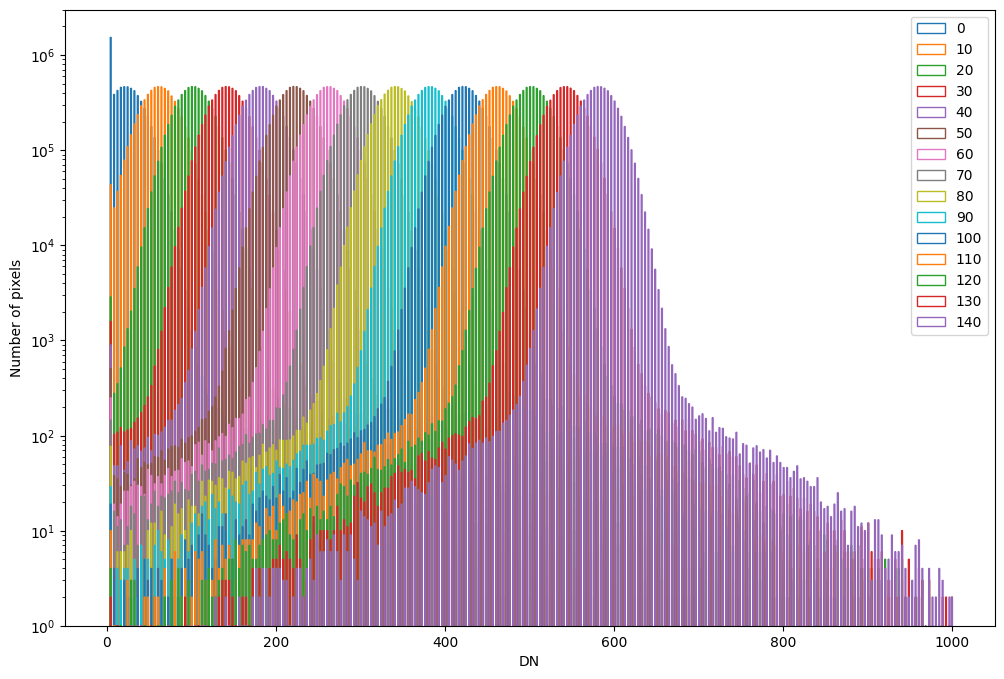

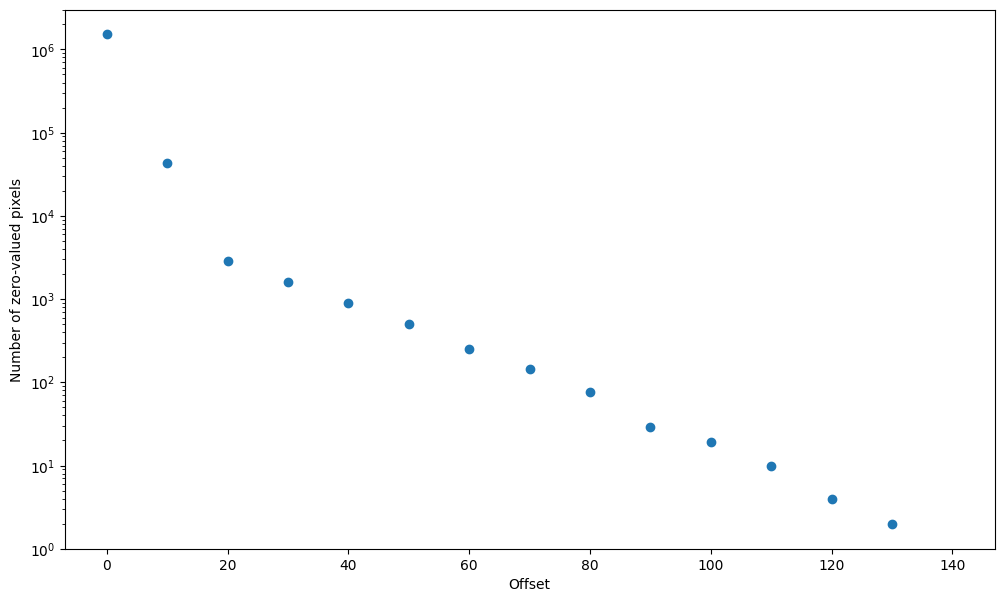

In [90]:
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

# 2600 100 = 15, 200 = 50
# 178  000 = 45, 100 = 140, 200 =

path = r'C:\Users\fauchere\Pictures\ZWO ASI178MM-Cool\2023-07-08\BIAS\G100'
# path = r'C:\Users\fauchere\Pictures\ZWO ASI2600MM Pro\2023-07-08\BIAS\G100'

files = glob.glob(os.path.join(path, '*.fits'))
offsets = np.array([fits.getheader(file)['OFFSET'] for file in files])
offsets, files = zip(*sorted(zip(offsets, files)))
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

zeros = []
for file, offset in zip(files, offsets):
    data = fits.getdata(file)
    zero = (data == 4).sum()
    zeros.append(zero)
    ax.hist(data.flatten(), histtype='step', bins=1000, range=[0, 1000], label=f'{offset}')

ax.set_xlabel('DN')
ax.set_ylabel('Number of pixels')

ax.set_ylim(1, 3e6)
ax.set_yscale('log')
ax.legend()

fig, ax = plt.subplots(1, 1, figsize=(12, 7))

ax.scatter(offsets, zeros)
ax.set_xlabel('Offset')
ax.set_ylabel('Number of zero-valued pixels')
ax.set_yscale('log')
ax.set_ylim(1, 3e6)
